# 📌 Sinh Caption cho Ảnh với BLIP và Bộ Dữ liệu COCO 2017

## 🎯 Giới thiệu
Đề tài này tập trung vào **bài toán Image Captioning** – tạo ra mô tả bằng ngôn ngữ tự nhiên cho một bức ảnh.  
Cụ thể, notebook này sử dụng:
- **BLIP (Bootstrapping Language-Image Pretraining)** – mô hình tiên tiến của HuggingFace cho nhiệm vụ sinh caption từ ảnh.
- **Bộ dữ liệu COCO 2017** – bộ dữ liệu chuẩn trong thị giác máy tính, bao gồm hàng trăm nghìn ảnh kèm nhiều chú thích.

## 🏗 Quy trình thực hiện
1️⃣ **Chuẩn bị môi trường & thư viện**: Cài đặt và import các thư viện cần thiết (PyTorch, Transformers, PIL…).  
2️⃣ **Tiền xử lý dữ liệu COCO**: Đọc annotation, ánh xạ ảnh với caption tương ứng.  
3️⃣ **Xây dựng Dataset tùy chỉnh**: Tạo class `COCODirectDataset` để kết hợp ảnh và caption qua `BlipProcessor`.  
4️⃣ **Tích hợp mô hình BLIP**: Sử dụng model `Salesforce/blip-image-captioning-base` từ HuggingFace.  
5️⃣ **Sinh caption và minh họa kết quả**: Cho ảnh vào model để tạo caption, hiển thị và đánh giá.

## ✅ Kết quả kỳ vọng
Notebook này sẽ cho thấy **cách xây dựng pipeline sinh caption hoàn chỉnh** từ dữ liệu thô đến kết quả trực quan, đồng thời tạo nền tảng cho việc **fine-tuning** hoặc triển khai vào ứng dụng thực tế (như trợ lý AI cho người khiếm thị hoặc quản lý ảnh thông minh).


In [1]:
import torch, transformers
print(torch.__version__)
print(transformers.__version__)


2.6.0+cu124
4.52.4


In [2]:
print("Nguyen Quoc Huy")

Nguyen Quoc Huy


1️⃣ Chuẩn bị môi trường & thư viện: Cài đặt và import các thư viện cần thiết (PyTorch, Transformers, PIL…).

In [3]:
import os
import json
import torch
import random
from PIL import Image
from tqdm import tqdm
from torch.optim import AdamW
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipForConditionalGeneration, get_scheduler

2025-08-03 12:42:26.539182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754224946.716871      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754224946.768326      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2️⃣ Tiền xử lý dữ liệu COCO: Đọc annotation, ánh xạ ảnh với caption tương ứng.


 Ảnh: 000000367332.jpg
 Kích thước: 640x480
 Caption: A elephant that is standing in the dirt.


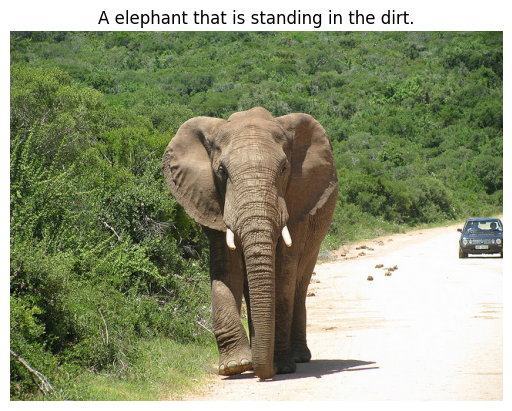


 Ảnh: 000000108826.jpg
 Kích thước: 640x427
 Caption: A large umbrella and sail at the beach with a sail in the air.


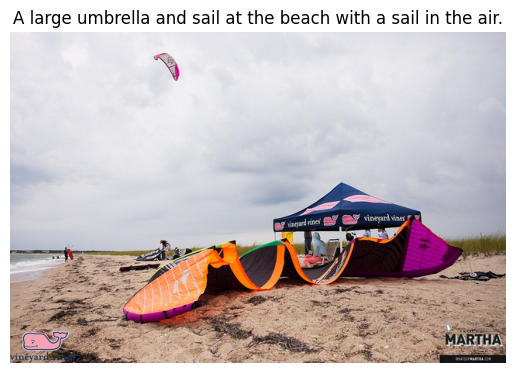


 Ảnh: 000000233153.jpg
 Kích thước: 640x584
 Caption: A man and woman smile for a picture.


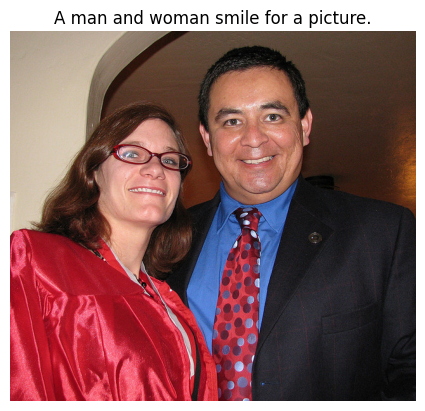


 Ảnh: 000000172475.jpg
 Kích thước: 375x500
 Caption: A book bag with a bottle in it next to a suitcase.


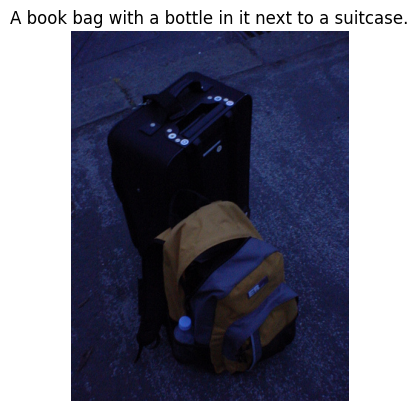


 Ảnh: 000000337584.jpg
 Kích thước: 640x480
 Caption: A young man riding a skateboard up the side of a cement ramp.


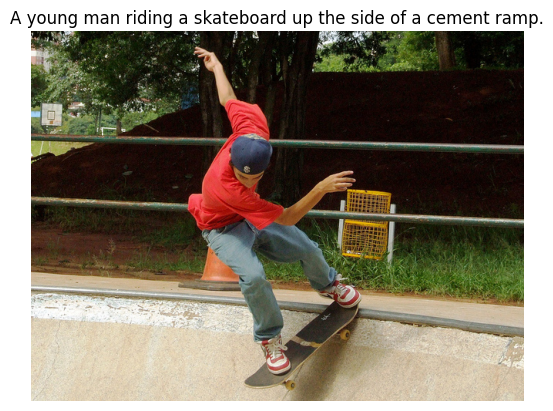

In [4]:
ANNOTATION_PATH = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json"
IMG_DIR = "/kaggle/input/coco-2017-dataset/coco2017/train2017"

with open(ANNOTATION_PATH, 'r') as f:
    coco_data = json.load(f)

id_to_info = {img['id']: img for img in coco_data['images']}

import random
N = 5
samples = random.sample(coco_data['annotations'], N)

for ann in samples:
    image_id = ann['image_id']
    caption = ann['caption']
    
    img_info = id_to_info.get(image_id, None)
    if img_info is None:
        print(f" Không tìm thấy ảnh với id: {image_id}")
        continue
    
    file_name = img_info['file_name']
    file_path = os.path.join(IMG_DIR, file_name)

    print(f"\n Ảnh: {file_name}")
    print(f" Kích thước: {img_info['width']}x{img_info['height']}")
    print(f" Caption: {caption}")

    if os.path.exists(file_path):
        try:
            image = Image.open(file_path)
            plt.imshow(image)
            plt.axis("off")
            plt.title(caption)
            plt.show()
        except Exception as e:
            print(f" Lỗi khi mở ảnh: {e}")
    else:
        print(" Ảnh không tồn tại trong thư mục.")


In [5]:
caption_count = defaultdict(int)
for ann in coco_data['annotations']:
    caption_count[ann['image_id']] += 1

all_counts = list(caption_count.values())

print(f"Số lượng ảnh: {len(caption_count)}")
print(f"Caption mỗi ảnh (trung bình): {sum(all_counts)/len(all_counts):.2f}")
print(f"Thống kê chi tiết:")
print(Counter(all_counts))

Số lượng ảnh: 118287
Caption mỗi ảnh (trung bình): 5.00
Thống kê chi tiết:
Counter({5: 117972, 6: 312, 7: 3})


Cài đặt thư viện cần thiết cho mô hình

In [6]:
!pip install fsspec==2024.10.0 rich==13.9.3 pylibraft-cu12==24.12.0 rmm-cu12==24.12.0


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 78.5 MB/s eta 0:00:00
  Created wheel for pylibraft-cu12: filename=pylibraft_cu12-24.12.0-cp311-cp311-manylinux_2_28_x86_64.whl size=11802800 sha256=47d3915fd3cdf4022acbd0315f88b12155399ef0b0e77fcac050c459ab6b31b0
  Stored in directory: /root/.cache/pip/wheels/2a/67/73/9252ad4b3876078a9bca569565977dd588cb54f66bd3bf2e0d
Successfully built pylibraft-cu12
  Attempting uninstall: cuda-python
    Found existing installation: cuda-python 12.9.0
    Uninstalling cuda-python-12.9.0:
      Succ

Kiểm tra GPU

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Dùng thiết bị:", device)

 Dùng thiết bị: cuda


Đảm bảo dữ liệu train sẵn sàng.

In [8]:
COCO_ROOT = "/kaggle/input/coco-2017-dataset/coco2017"
TRAIN_IMG_DIR = f"{COCO_ROOT}/train2017"
ANNOTATION_PATH = f"{COCO_ROOT}/annotations/captions_train2017.json"

assert os.path.exists(TRAIN_IMG_DIR), " Thư mục ảnh train không tồn tại"
assert os.path.exists(ANNOTATION_PATH), " File annotation train không tồn tại"

with open(ANNOTATION_PATH, 'r') as f:
    coco_data = json.load(f)
print(" Đã load annotation train JSON")


 Đã load annotation train JSON


Chuẩn bị dữ liệu cho Dataset

In [9]:
import random

# Bước 1: ánh xạ image_id -> file_name
id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}

# Bước 2: ánh xạ image_id -> danh sách caption
image_captions = defaultdict(list)
for ann in coco_data['annotations']:
    img_id = ann['image_id']
    caption = ann['caption']
    image_captions[img_id].append(caption)

# Bước 3: lọc các ảnh thực sự tồn tại trong thư mục train
valid_image_ids = []
for img_id, file_name in id_to_filename.items():
    img_path = os.path.join(TRAIN_IMG_DIR, file_name)
    if os.path.exists(img_path) and img_id in image_captions:
        valid_image_ids.append(img_id)

# Bước 4: sort image_id để lấy 30k ảnh
valid_image_ids = sorted(valid_image_ids)
selected_ids = valid_image_ids[1:30001]  # lấy 30k ảnh

# Bước 5: tạo annotation final (mỗi ảnh random 1 caption)
annotations = []
for img_id in selected_ids:
    file_name = id_to_filename[img_id]
    caption = random.choice(image_captions[img_id])  # chọn ngẫu nhiên 1 caption
    annotations.append({"image": file_name, "caption": caption})

print(f"✅ Đã chọn {len(selected_ids)} ảnh, tổng {len(annotations)} caption (mỗi ảnh 1 caption ngẫu nhiên).")

# Kiểm tra phân phối caption
train_caption_per_image = defaultdict(int)
for item in annotations:
    train_caption_per_image[item["image"]] += 1

print(f"🧾 Train: {len(annotations)} caption trên {len(train_caption_per_image)} ảnh")
print(f"📈 Phân phối caption/ảnh (train): {dict(Counter(train_caption_per_image.values()))}")


✅ Đã chọn 30000 ảnh, tổng 30000 caption (mỗi ảnh 1 caption ngẫu nhiên).
🧾 Train: 30000 caption trên 30000 ảnh
📈 Phân phối caption/ảnh (train): {1: 30000}


Xây dựng Dataset custom để model dùng trực tiếp

In [10]:
class COCODirectDataset(Dataset):
    def __init__(self, annotations, img_dir, processor, max_length=128):
        self.data = annotations
        self.img_dir = img_dir
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img_path = os.path.join(self.img_dir, item["image"])
        caption = item["caption"]

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f" Lỗi khi mở ảnh: {img_path} — {e}")
            image = Image.new("RGB", (224, 224), (0, 0, 0))

        inputs = self.processor(images=image, text=caption, padding="max_length",
                                truncation=True, max_length=self.max_length, return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs

Chuẩn bị dữ liệu đã sẵn sàng cho training.

In [11]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
train_dataset = COCODirectDataset(annotations, TRAIN_IMG_DIR, processor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
print(f" DataLoader train — {len(train_dataset)} samples")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

 DataLoader train — 30000 samples


Lấy BLIP model pretrained, đóng băng phần xử lý ảnh (vision encoder) để tiết kiệm tài nguyên

In [12]:
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

for param in model.vision_model.parameters():
    param.requires_grad = False

print(f" Model params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
print(f" Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M")


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

 Model params: 247.41M
 Trainable params: 161.32M


Chuẩn bị dữ liệu validation để đánh giá model.

In [13]:
VAL_IMG_DIR = f"{COCO_ROOT}/val2017"
VAL_ANN_PATH = f"{COCO_ROOT}/annotations/captions_val2017.json"

assert os.path.exists(VAL_IMG_DIR), " Thư mục ảnh val không tồn tại"
assert os.path.exists(VAL_ANN_PATH), " File annotation val không tồn tại"

with open(VAL_ANN_PATH, "r") as f:
    val_data = json.load(f)

val_id_to_file = {img["id"]: img["file_name"] for img in val_data["images"]}
val_annotations = []
for ann in val_data["annotations"]:
    img_id = ann["image_id"]
    if img_id in val_id_to_file:
        file_name = val_id_to_file[img_id]
        img_path = os.path.join(VAL_IMG_DIR, file_name)
        if os.path.exists(img_path):
            val_annotations.append({"image": file_name, "caption": ann["caption"]})

random.seed(123)
val_annotations = random.sample(val_annotations, 5000)
print(f"✅ Số sample validation: {len(val_annotations)}")

val_caption_per_image = defaultdict(int)
for item in val_annotations:
    val_caption_per_image[item["image"]] += 1
print(f"🧾 Validation: {len(val_annotations)} caption trên {len(val_caption_per_image)} ảnh")
print(f"📈 Phân phối caption/ảnh (val): {dict(Counter(val_caption_per_image.values()))}")

train_images = set(item["image"] for item in annotations)
val_images = set(item["image"] for item in val_annotations)
overlap = train_images.intersection(val_images)
print(f"⚠️ Số ảnh trùng giữa train và val: {len(overlap)}")

val_dataset = COCODirectDataset(val_annotations, VAL_IMG_DIR, processor)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
print(f"✅ DataLoader valid — {len(val_dataset)} samples")


✅ Số sample validation: 5000
🧾 Validation: 5000 caption trên 3379 ảnh
📈 Phân phối caption/ảnh (val): {2: 1062, 1: 2054, 3: 230, 4: 33}
⚠️ Số ảnh trùng giữa train và val: 0
✅ DataLoader valid — 5000 samples


Chuẩn bị cơ chế tối ưu cho training.



In [14]:
def setup_optimizer_scheduler(model, train_loader, lr=5e-5, epochs=3):
    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * epochs
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    print(f" AdamW + Scheduler  — Total steps: {total_steps}")
    return optimizer, scheduler

optimizer, scheduler = setup_optimizer_scheduler(model, train_loader)

 AdamW + Scheduler  — Total steps: 5625


In [15]:
def train(model, train_loader, val_loader, optimizer, scheduler, device, epochs=3):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"🚀 Epoch {epoch+1}/{epochs}")

        for batch in pbar:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch, labels=batch["input_ids"])
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            pbar.set_postfix(train_loss=loss.item())

        avg_train_loss = total_loss / len(train_loader)
        print(f"✅ Epoch {epoch+1} — Train loss: {avg_train_loss:.4f}")

        evaluate(model, val_loader, device)


In [16]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch, labels=batch["input_ids"])
            total_loss += outputs.loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f" Validation Loss: {avg_loss:.4f}")
    model.train()
    return avg_loss


In [17]:
train(model, train_loader, val_loader, optimizer, scheduler, device, epochs=3)

🚀 Epoch 1/3: 100%|██████████| 1875/1875 [32:49<00:00,  1.05s/it, train_loss=0.177]


✅ Epoch 1 — Train loss: 0.3662
 Validation Loss: 0.1831


🚀 Epoch 2/3: 100%|██████████| 1875/1875 [30:14<00:00,  1.03it/s, train_loss=0.145]


✅ Epoch 2 — Train loss: 0.1550
 Validation Loss: 0.1825


🚀 Epoch 3/3: 100%|██████████| 1875/1875 [30:13<00:00,  1.03it/s, train_loss=0.117]


✅ Epoch 3 — Train loss: 0.1262
 Validation Loss: 0.1864


In [18]:
def generate_caption(model, processor, image_path, device, max_length=32):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    model.eval()
    with torch.no_grad():
        output_ids = model.generate(**inputs, max_length=max_length)
        caption = processor.tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return caption


In [19]:
def preview_val_predictions(model, processor, val_data, img_dir, device, num_samples=5):
    samples = random.sample(val_data, num_samples)
    for sample in samples:
        img_path = os.path.join(img_dir, sample["image"])
        gt_caption = sample["caption"]
        try:
            pred_caption = generate_caption(model, processor, img_path, device)
            image = Image.open(img_path).convert("RGB")
            plt.imshow(image)
            plt.axis("off")
            plt.title(f"📌 Pred: {pred_caption}\n✅ GT: {gt_caption}", fontsize=9)
            plt.show()
        except Exception as e:
            print(f"❌ Lỗi ảnh {img_path}: {e}")


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


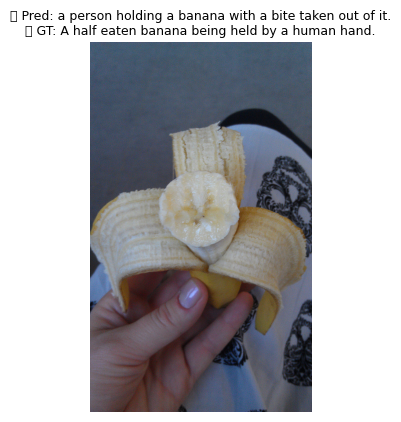

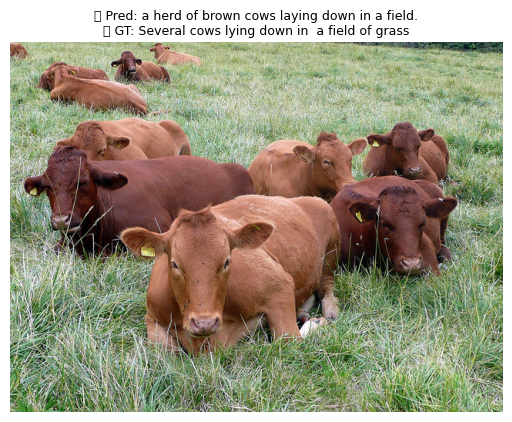

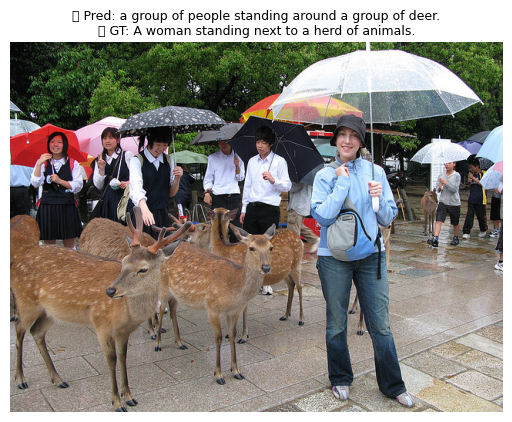

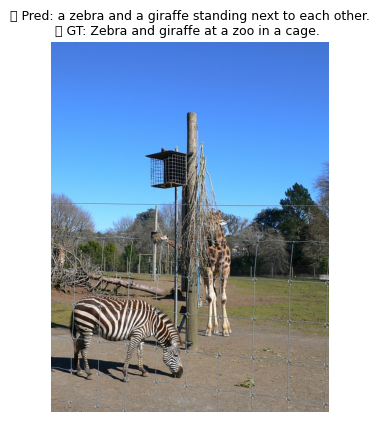

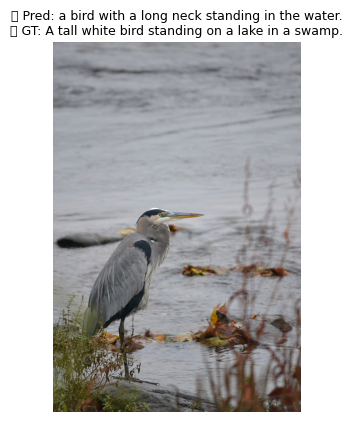

In [20]:
preview_val_predictions(model, processor, val_annotations, VAL_IMG_DIR, device, num_samples=5)

In [21]:
OUTPUT_DIR = "./blip-captioning-final"

model.save_pretrained(OUTPUT_DIR)
processor.save_pretrained(OUTPUT_DIR)

print(f"✅ Mô hình và processor đã được lưu tại: {OUTPUT_DIR}")


✅ Mô hình và processor đã được lưu tại: ./blip-captioning-final
